In [2]:
import os
import numpy as np

import analysis_utils as utils

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [91]:
colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", 
          "#beb9db", "#fdcce5", "#8bd3c7"]
continuous_colors = ["#54bebe", "#76c8c8", "#98d1d1", "#badbdb", "#dedad2", 
                     "#e4bcad", "#df979e", "#d7658b", "#c80064"]
custom_palette = {'l': colors[1], 's': colors[0]}

In [139]:
cohort = 'cohort_3'
to_analyze = 'full_clean_stitched'
data_dir = '/Users/rebekahzhang/Documents/shuler_lab/behavior_data'
data_folder = os.path.join(data_dir, cohort, to_analyze)
figure_folder = os.path.join(data_dir, cohort, 'figures_lick')
print(data_folder)
print(figure_folder)

/Users/rebekahzhang/Documents/shuler_lab/behavior_data/cohort_3/full_clean_stitched
/Users/rebekahzhang/Documents/shuler_lab/behavior_data/cohort_3/figures_lick


## load session log

In [140]:
training_session_log = utils.load_session_log(data_folder, 'stitched_training_sessions.csv')

In [141]:
session_log_by_mouse = training_session_log.groupby('mouse')

### plot tw ecdf by mouse

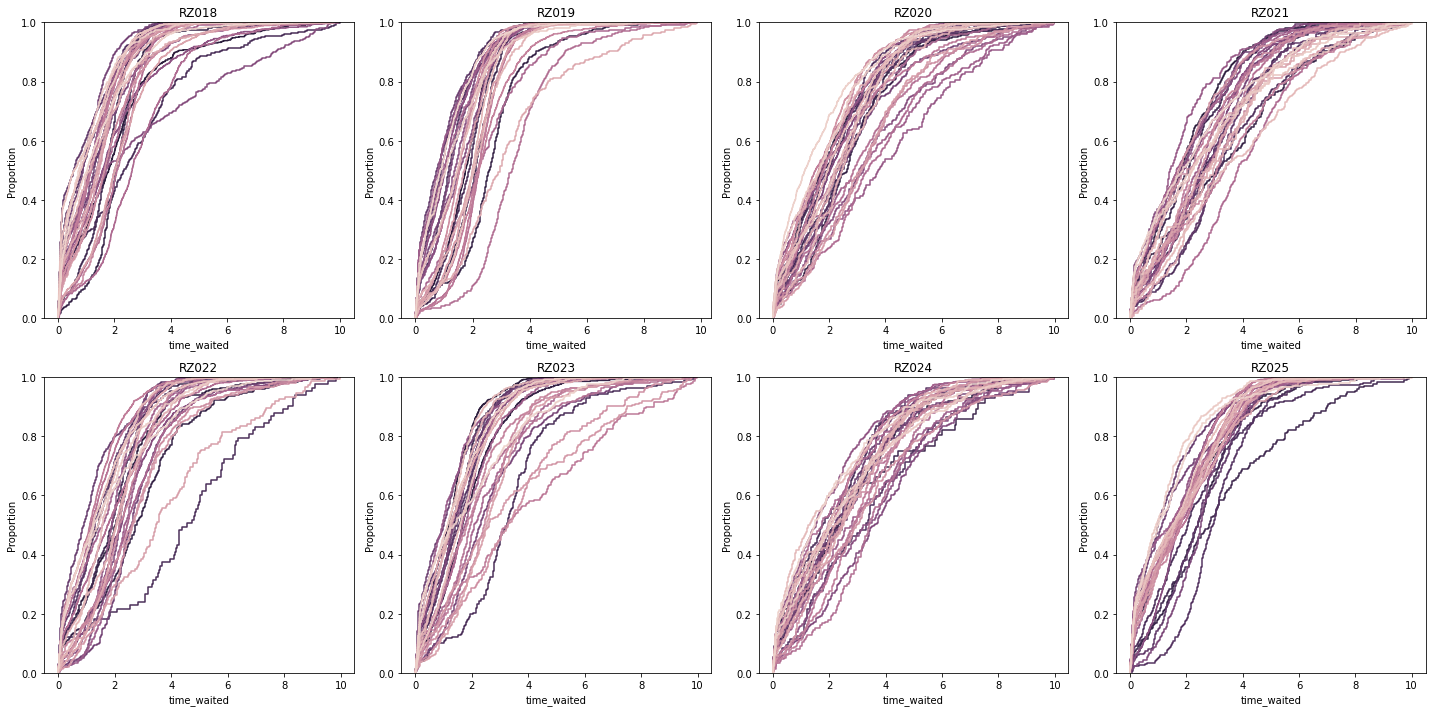

In [13]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows, 3 columns

for i, (m, mouse) in enumerate(session_log_by_mouse):
    df_list = []
    ax=axs.flat[i]
    for d, dir_name in enumerate(mouse.dir):
        all_trials = utils.load_all_trials_analyzed(data_folder, dir_name)
        all_trials['days'] = d
        df_list.append(all_trials)
    
    all_trials_all_days = pd.concat(df_list, ignore_index=True)
    sns.ecdfplot(data=all_trials_all_days, x='time_waited', hue='days', ax=ax, legend=None)

    ax.set_title(m)

plt.tight_layout()
plt.savefig(f'{figure_folder}/tw_ecdf.png', bbox_inches='tight', dpi=300)
plt.show()

## plot lick kde for all mice

In [33]:
cohort = 'cohort_3'
to_analyze = 'full_clean_stitched_all_mice'
data_dir = '/Users/rebekahzhang/Documents/shuler_lab/behavior_data'
data_folder = os.path.join(data_dir, cohort, to_analyze)
figure_folder = os.path.join(data_dir, cohort, 'figures_lick')
print(data_folder)
print(figure_folder)

/Users/rebekahzhang/Documents/shuler_lab/behavior_data/cohort_3/full_clean_stitched_all_mice
/Users/rebekahzhang/Documents/shuler_lab/behavior_data/cohort_3/figures_lick


In [39]:
training_session_log = utils.load_session_log(data_folder, 'stitched_all_mice_training_sessions.csv')
training_session_log = training_session_log.iloc[1:] # dropping first day cuz only 4 mice trained

In [42]:
def calculate_subplot_row_col(session_mouse, plots_per_row):
    days_trained = len(session_mouse)
    num_rows = (days_trained - 1) // plots_per_row + 1
    num_cols = min(days_trained, plots_per_row)
    return num_rows, num_cols

In [60]:
def generate_event_aligned_all_mice_session_path(data_folder, d):
    return os.path.join(data_folder, f'{d}', f'aligned_processed_data_{d}.csv')

In [69]:
def get_event_times_hack(trial):
    cue_on = trial.loc[(trial['key'] == 'visual') & (trial['value'] == 1), 'trial_time'].iloc[0]
    cue_off = trial.loc[(trial['key'] == 'visual') & (trial['value'] == 0), 'trial_time'].iloc[0]
    if 'reward' in trial.key.unique():
        reward = trial.loc[(trial['key'] == 'reward') & (trial['value'] == 1), 'trial_time'].iloc[0]
    else:
        reward = np.nan
    return {'cue_on': cue_on, 
            'cue_off': cue_off,
            'reward': reward}

In [73]:
def align_trial_time_by_events_hack(trial):
    event_times = get_event_times_hack(trial)
    trial['time_by_cue_on'] = trial['trial_time'] - event_times['cue_on']
    trial['time_by_cue_off'] = trial['trial_time'] - event_times['cue_off']
    trial['time_by_reward'] = trial['trial_time'] - event_times['reward']
    if event_times['cue_off'] - event_times['cue_on'] < 2:
        trial['blk_type'] = 's'
    else:
        trial['blk_type'] = 'l'
    return trial

In [62]:
def get_event_times(trial):
    cue_on = trial.loc[(trial['key'] == 'visual') & (trial['value'] == 1), 'trial_time'].iloc[0]
    cue_off = trial.loc[(trial['key'] == 'visual') & (trial['value'] == 0), 'trial_time'].iloc[0]
    if 'reward' in trial.key.unique():
        reward = trial.loc[(trial['key'] == 'reward') & (trial['value'] == 1), 'trial_time'].iloc[0]
    else:
        reward = np.nan
    return {'cue_on': cue_on, 
            'cue_off': cue_off,
            'reward': reward}

In [63]:
def align_trial_time_by_events(trial):
    event_times = get_event_times(trial)
    trial['time_by_cue_on'] = trial['trial_time'] - event_times['cue_on']
    trial['time_by_cue_off'] = trial['trial_time'] - event_times['cue_off']
    trial['time_by_reward'] = trial['trial_time'] - event_times['reward']
    return trial

In [74]:
for s, sess in training_session_log.iterrows():
    processed_session = utils.load_stitched_all_mice_session(data_folder, sess['date'])
    session_by_trial = processed_session.groupby('session_trial_num', group_keys=True)
    session = session_by_trial.apply(align_trial_time_by_events_hack).reset_index(drop=True)
    path = generate_event_aligned_all_mice_session_path(data_folder, sess['date'])
    session.to_csv(path)

In [75]:
def load_aligned_stitched_all_mice_session(data_folder, d):
    path = generate_event_aligned_all_mice_session_path(data_folder, d)
    session_df = pd.read_csv(path, index_col=0)
    return session_df

In [76]:
def remove_unused_subplot(d, num_rows, num_cols, axs):
    if d + 1 < num_rows * num_cols:
        for j in range(d + 1, num_rows * num_cols):
            axs.flat[j].axis('off')
    return axs

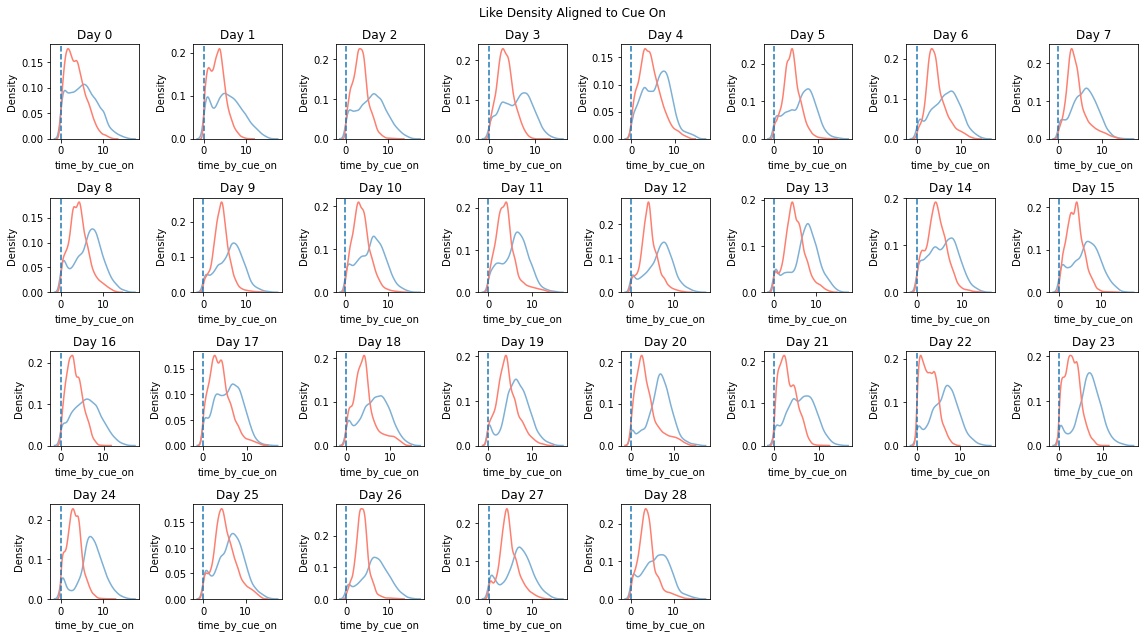

In [85]:
num_rows, num_cols = calculate_subplot_row_col(training_session_log, 8)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 2.25 * num_rows))
for d, (_, sess) in enumerate(training_session_log.iterrows()):
    ax = axs.flat[d]
    session = load_aligned_stitched_all_mice_session(data_folder, sess['date'])
    licks = session[(session['key'] == 'lick') & (session['value'] == 1)]
    sns.kdeplot(data=licks, x="time_by_cue_on", hue='blk_type', 
                common_norm=False, palette=custom_palette, ax=ax, legend=False)
    ax.axvline(x=0, linestyle='--')
    ax.set_title(f'Day {d}')
remove_unused_subplot(d, num_rows, num_cols, axs)
fig.suptitle('Like Density Aligned to Cue On')
plt.tight_layout()
plt.savefig(f'{figure_folder}/lick_kde_cue_on.png', bbox_inches='tight', dpi=300)

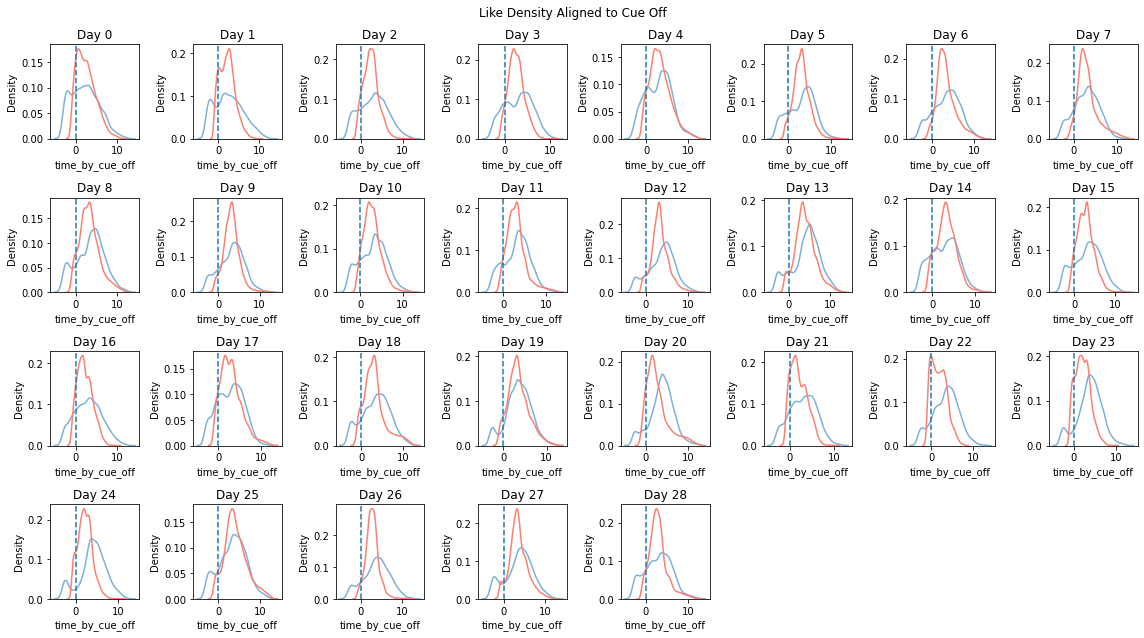

In [83]:
num_rows, num_cols = calculate_subplot_row_col(training_session_log, 8)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 2.25 * num_rows))
for d, (_, sess) in enumerate(training_session_log.iterrows()):
    ax = axs.flat[d]
    session = load_aligned_stitched_all_mice_session(data_folder, sess['date'])
    licks = session[(session['key'] == 'lick') & (session['value'] == 1)]
    sns.kdeplot(data=licks, x="time_by_cue_off", hue='blk_type', 
                common_norm=False, palette=custom_palette, ax=ax, legend=False)
    ax.axvline(x=0, linestyle='--')
    ax.set_title(f'Day {d}')
fig.suptitle('Like Density Aligned to Cue Off')
remove_unused_subplot(d, num_rows, num_cols, axs)
plt.tight_layout()
plt.savefig(f'{figure_folder}/lick_kde_cue_off.png', bbox_inches='tight', dpi=300)

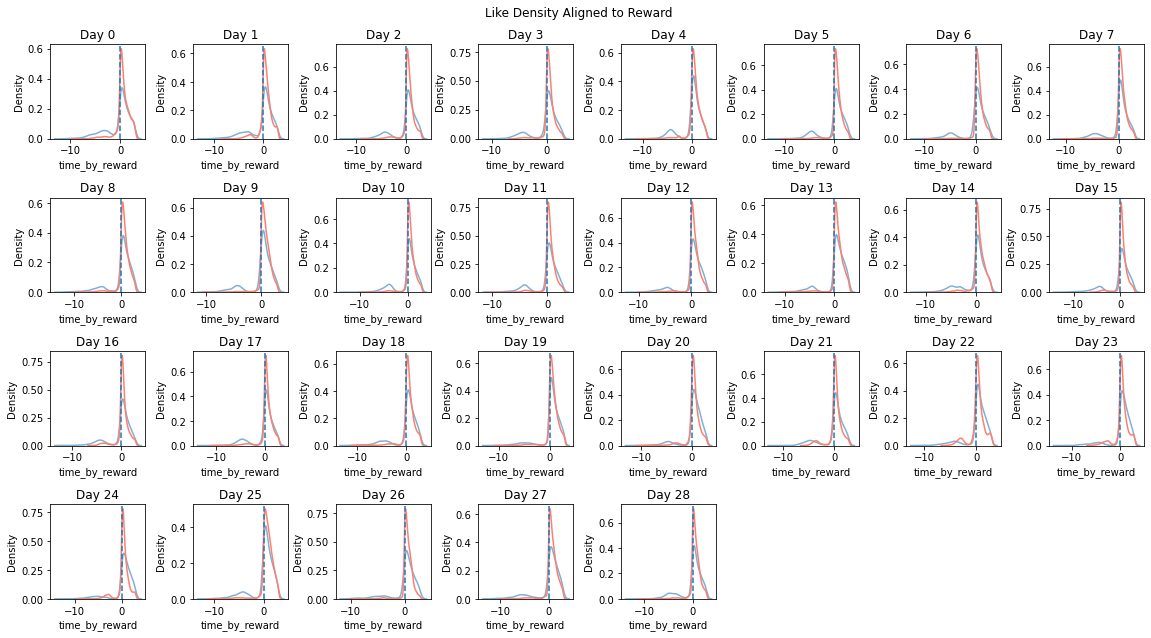

In [84]:
num_rows, num_cols = calculate_subplot_row_col(training_session_log, 8)
fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 2.25 * num_rows))
for d, (_, sess) in enumerate(training_session_log.iterrows()):
    ax = axs.flat[d]
    session = load_aligned_stitched_all_mice_session(data_folder, sess['date'])
    licks = session[(session['key'] == 'lick') & (session['value'] == 1)]
    sns.kdeplot(data=licks, x="time_by_reward", hue='blk_type', 
                common_norm=False, palette=custom_palette, ax=ax, legend=False)
    ax.axvline(x=0, linestyle='--')
    ax.set_title(f'Day {d}')
fig.suptitle('Like Density Aligned to Reward')
remove_unused_subplot(d, num_rows, num_cols, axs)
plt.tight_layout()
plt.savefig(f'{figure_folder}/lick_kde_reward.png', bbox_inches='tight', dpi=300)

## Plot lick for each mouse

In [99]:
short_list = ['RZ018', 'RZ019', 'RZ022', 'RZ023']
long_list = ['RZ020', 'RZ021', 'RZ024', 'RZ025']

### Sort trials

In [93]:
def generate_trial_list_sorted(all_trials, sort_column):
    all_trials_sorted = all_trials.sort_values(by=[sort_column])
    trial_num_sorted = all_trials_sorted.session_trial_num.tolist()
    return trial_num_sorted

In [36]:
trial_num_by_tw = generate_trial_list_sorted(all_trials, 'time_waited')
trial_num_by_reward = generate_trial_list_sorted(all_trials, 'reward')
trial_num_by_bg_len = generate_trial_list_sorted(all_trials, 'bg_length')
trial_num_by_bg_licks = generate_trial_list_sorted(all_trials, 'num_bg_lick')

### lick histogram

In [52]:
def get_event_times(trial):
    cue_on = trial.loc[(trial['key'] == 'visual') & (trial['value'] == 1), 'trial_time'].iloc[0]
    cue_off = trial.loc[(trial['key'] == 'visual') & (trial['value'] == 0), 'trial_time'].iloc[0]
    if 'reward' in trial.key.unique():
        reward = trial.loc[(trial['key'] == 'reward') & (trial['value'] == 1), 'trial_time'].iloc[0]
    else:
        reward = np.nan
    return {'cue_on': cue_on, 
            'cue_off': cue_off,
            'reward': reward}

In [50]:
def align_trial_time_by_events(trial):
    event_times = get_event_times(trial)
    trial['time_by_cue_on'] = trial['trial_time'] - event_times['cue_on']
    trial['time_by_cue_off'] = trial['trial_time'] - event_times['cue_off']
    trial['time_by_reward'] = trial['trial_time'] - event_times['reward']
    return trial

add event timing for each trial and save session

In [59]:
def generate_event_aligned_session_path(data_folder, m, d):
    return os.path.join(data_folder, f'{d}_{m}', f'aligned_processed_data_{m}_{d}.csv')

In [10]:
for s, sess in training_session_log.iterrows():
    processed_session = utils.load_stitched_session(data_folder, sess['mouse'], sess['date'])
    session_by_trial = processed_session.groupby('session_trial_num', group_keys=True)
    session = session_by_trial.apply(align_trial_time_by_events).reset_index(drop=True)
    path = generate_event_aligned_session_path(data_folder, sess['mouse'], sess['date'])
    session.to_csv(path)

plot lick density aligned by event time

In [11]:
def calculate_subplot_row_col(session_mouse, plots_per_row):
    days_trained = len(session_mouse)
    num_rows = (days_trained - 1) // plots_per_row + 1
    num_cols = min(days_trained, plots_per_row)
    return num_rows, num_cols

In [94]:
def load_aligned_stitched_session(data_folder, m, d):
    path = generate_event_aligned_session_path(data_folder, m, d)
    session_df = pd.read_csv(path, index_col=0)
    return session_df

In [13]:
def remove_unused_subplot(d, num_rows, num_cols, axs):
    if d + 1 < num_rows * num_cols:
        for j in range(d + 1, num_rows * num_cols):
            axs.flat[j].axis('off')
    return axs

### plot kde for each time anchor

In [102]:
def set_color(mouse, long_list, short_list):
    if mouse in short_list:
        color = custom_palette['s']
    elif mouse in long_list:
        color = custom_palette['l']
    return color

time by cue on

In [101]:
for m, mouse in session_log_by_mouse:
    color = set_color(m, long_list, short_list)
    num_rows, num_cols = calculate_subplot_row_col(mouse, 8)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 2.25 * num_rows))
    for d, (s, sess) in enumerate(mouse.iterrows()):
        ax = axs.flat[d]
        session = load_aligned_stitched_session(data_folder, sess['mouse'], sess['date'])
        licks = session[(session['key'] == 'lick') & (session['value'] == 1)]
        sns.kdeplot(data=licks, x="time_by_cue_on", color=color, ax=ax)
        ax.set_xlim(-1, 15)
        ax.set_ylim(0, 0.4)
        ax.axvline(x=0, linestyle='--')
        ax.set_title(f'Day {d+1}')
    fig.suptitle(m)
    remove_unused_subplot(d, num_rows, num_cols, axs)
    plt.tight_layout()
    plt.savefig(f'{figure_folder}/lick_kde_cue_on_{m}.png', bbox_inches='tight', dpi=300)
    plt.close()

time by cue off

In [103]:
for m, mouse in session_log_by_mouse:
    color = set_color(m, long_list, short_list)
    num_rows, num_cols = calculate_subplot_row_col(mouse, 8)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 2.25 * num_rows))
    for d, (s, sess) in enumerate(mouse.iterrows()):
        ax = axs.flat[d]
        session = load_aligned_stitched_session(data_folder, sess['mouse'], sess['date'])
        licks = session[(session['key'] == 'lick') & (session['value'] == 1)]
        sns.kdeplot(data=licks, x="time_by_cue_off", color=color, ax=ax)
        ax.set_xlim(-5, 12)
        ax.set_ylim(0, 0.4)
        ax.axvline(x=0, linestyle='--')
        ax.set_title(f'Day {d+1}')
    fig.suptitle(m)
    remove_unused_subplot(d, num_rows, num_cols, axs)
    plt.tight_layout()
    plt.savefig(f'{figure_folder}/lick_kde_cue_off_{m}.png', bbox_inches='tight', dpi=300)
    plt.close()

time by reward

In [104]:
for m, mouse in session_log_by_mouse:
    color = set_color(m, long_list, short_list)
    num_rows, num_cols = calculate_subplot_row_col(mouse, 8)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 2.25 * num_rows))
    for d, (s, sess) in enumerate(mouse.iterrows()):
        ax = axs.flat[d]
        session = load_aligned_stitched_session(data_folder, sess['mouse'], sess['date'])
        licks = session[(session['key'] == 'lick') & (session['value'] == 1)]
        sns.kdeplot(data=licks, x="time_by_reward", color=color, ax=ax)
        ax.set_xlim(-10, 3)
        ax.axvline(x=0, linestyle='--')
        ax.set_title(f'Day {d+1}')
    fig.suptitle(m)
    remove_unused_subplot(d, num_rows, num_cols, axs)
    plt.tight_layout()
    plt.savefig(f'{figure_folder}/lick_kde_reward_{m}.png', bbox_inches='tight', dpi=300)
    plt.close()

### plot histo with each time anchor

time by cue on

In [105]:
for m, mouse in session_log_by_mouse:
    color = set_color(m, long_list, short_list)
    num_rows, num_cols = calculate_subplot_row_col(mouse, 8)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 2.25 * num_rows))
    for d, (s, sess) in enumerate(mouse.iterrows()):
        ax = axs.flat[d]
        session = load_aligned_stitched_session(data_folder, sess['mouse'], sess['date'])
        licks = session[(session['key'] == 'lick') & (session['value'] == 1)]
        sns.histplot(data=licks, x="time_by_cue_on", color=color, ax=ax)
        ax.set_xlim(-2, 15)
        ax.axvline(x=0, linestyle='--')
        ax.set_title(f'Day {d+1}')
    fig.suptitle(m)
    remove_unused_subplot(d, num_rows, num_cols, axs)
    plt.tight_layout()
    plt.savefig(f'{figure_folder}/lick_histo_cue_on_{m}.png', bbox_inches='tight', dpi=300)
    plt.close()

time by cue off

In [106]:
for m, mouse in session_log_by_mouse:
    color = set_color(m, long_list, short_list)
    num_rows, num_cols = calculate_subplot_row_col(mouse, 8)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 2.25 * num_rows))
    for d, (s, sess) in enumerate(mouse.iterrows()):
        ax = axs.flat[d]
        session = load_aligned_stitched_session(data_folder, sess['mouse'], sess['date'])
        licks = session[(session['key'] == 'lick') & (session['value'] == 1)]
        sns.histplot(data=licks, x="time_by_cue_off", color=color, ax=ax)
        ax.set_xlim(-2, 15)
        ax.axvline(x=0, linestyle='--')
        ax.set_title(f'Day {d+1}')
    fig.suptitle(m)
    remove_unused_subplot(d, num_rows, num_cols, axs)
    plt.tight_layout()
    plt.savefig(f'{figure_folder}/lick_histo_cue_off_{m}.png', bbox_inches='tight', dpi=300)
    plt.close()

time by reward

In [107]:
for m, mouse in session_log_by_mouse:
    color = set_color(m, long_list, short_list)
    num_rows, num_cols = calculate_subplot_row_col(mouse, 8)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 2.25 * num_rows))
    for d, (s, sess) in enumerate(mouse.iterrows()):
        ax = axs.flat[d]
        session = load_aligned_stitched_session(data_folder, sess['mouse'], sess['date'])
        licks = session[(session['key'] == 'lick') & (session['value'] == 1)]
        sns.histplot(data=licks, x="time_by_reward", color=color, ax=ax)
        ax.set_xlim(-10, 3)
        ax.axvline(x=0, linestyle='--')
        ax.set_title(f'Day {d+1}')
    fig.suptitle(m)
    remove_unused_subplot(d, num_rows, num_cols, axs)
    plt.tight_layout()
    plt.savefig(f'{figure_folder}/lick_histo_reward_{m}.png', bbox_inches='tight', dpi=300)
    plt.close()

## plot lick raster

In [88]:
def load_stitched_session_files(sess, data_folder):
    session = load_aligned_stitched_session(data_folder, sess['mouse'], sess['date'])
    session_by_trial = session.groupby('session_trial_num', group_keys=True)
    all_trials = utils.load_stitched_all_trials_analyzed(data_folder, sess['mouse'], sess['date'])
    return session_by_trial, all_trials

plot lick raster aligned by cue off sorted by time wait

In [165]:
def plot_raster_by_cue_on(sorter):
    anchor = 'time_by_cue_on'
    for m, mouse in session_log_by_mouse:
        color = set_color(m, long_list, short_list)
        num_rows, num_cols = calculate_subplot_row_col(mouse, 8)
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 2.25 * num_rows))
        for d, (s, sess) in enumerate(mouse.iterrows()):
            ax = axs.flat[d]
            session_by_trial, all_trials = load_stitched_session_files(sess, data_folder)
            trial_num_sorted = generate_trial_list_sorted(all_trials, sorter)
            for i, t in enumerate(trial_num_sorted):
                trial = session_by_trial.get_group(t)
                licks = trial[(trial['key'] == 'lick') & (trial['value'] == 1)]
                ax.eventplot(licks[anchor], color=color, linelengths=0.5, lineoffsets=i)
            ax.set_xlim(0, 13)
            ax.axvline(x=0)
            ax.set_title(f'Day {d+1}')
        fig.suptitle(f'{anchor}_{m}')
        remove_unused_subplot(d, num_rows, num_cols, axs)
        plt.tight_layout()
        plt.savefig(f'{figure_folder}/raster_{anchor}_{sorter}_{m}.png', bbox_inches='tight', dpi=300)
        plt.close()

In [136]:
plot_raster_by_cue_on('time_waited')

In [159]:
plot_raster_by_cue_on('num_bg_lick')

In [166]:
plot_raster_by_cue_on('session_trial_num')

plotting lick raster anchored by cue off

In [131]:
def plot_raster_by_cue_off(sorter):
    anchor = 'time_by_cue_off'
    for m, mouse in session_log_by_mouse:
        color = set_color(m, long_list, short_list)
        num_rows, num_cols = calculate_subplot_row_col(mouse, 8)
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 2.25 * num_rows))
        for d, (_, sess) in enumerate(mouse.iterrows()):
            ax = axs.flat[d]
            session_by_trial, all_trials = load_stitched_session_files(sess, data_folder)
            trial_num_sorted = generate_trial_list_sorted(all_trials, sorter)
            for i, t in enumerate(trial_num_sorted):
                trial = session_by_trial.get_group(t)
                licks = trial[(trial['key'] == 'lick') & (trial['value'] == 1)]
                ax.eventplot(licks[anchor], color=color, lineoffsets=i)
            ax.set_xlim(-3, 13)
            ax.axvline(x=0)
            ax.axvline(x=all_trials.time_waited.mean(), linestyle='--')
            ax.set_title(f'Day {d+1}')
        fig.suptitle(f'{anchor}_{m}')
        remove_unused_subplot(d, num_rows, num_cols, axs)
        plt.tight_layout()
        plt.savefig(f'{figure_folder}/raster_{anchor}_{sorter}_{m}.png', bbox_inches='tight', dpi=300)
        plt.close()

In [132]:
plot_raster_by_cue_off('time_waited')

In [144]:
sess = training_session_log.loc[(training_session_log.mouse=='RZ018') & (training_session_log.session_num==25)]

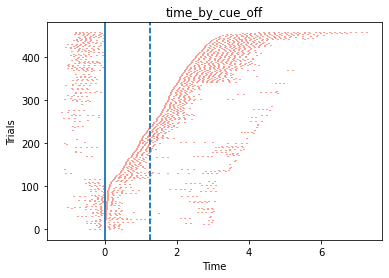

In [162]:
anchor = 'time_by_cue_off'
sorter = 'time_waited'
color = custom_palette['s']

plt.figure()
plt.axvline(x=0)
plt.axvline(x=all_trials.time_waited.mean(), linestyle='--')
session = load_aligned_stitched_session(data_folder, 'RZ018', '2023-09-08')
session_by_trial = session.groupby('session_trial_num', group_keys=True)
all_trials = utils.load_stitched_all_trials_analyzed(data_folder, 'RZ018', '2023-09-08')

trial_num_sorted = generate_trial_list_sorted(all_trials, sorter)
for i, t in enumerate(trial_num_sorted):
    trial = session_by_trial.get_group(t)
    licks = trial[(trial['key'] == 'lick') & (trial['value'] == 1)]
    licks_transposed = licks[anchor].T 
    plt.eventplot(licks_transposed, color=color, lineoffsets=i)

plt.axvline(x=0)
plt.axvline(x=all_trials.time_waited.mean(), linestyle='--')
plt.xlabel('Time')
plt.ylabel('Trials')
plt.title(anchor)
plt.savefig(f'{figure_folder}/raster_{anchor}_{sorter}_RZ018_2023-09-08.png', bbox_inches='tight', dpi=300)

plot lick raster anchored by reward

In [133]:
def plot_raster_by_reward(sorter):
    anchor = 'time_by_reward'
    for m, mouse in session_log_by_mouse:
        color = set_color(m, long_list, short_list)
        num_rows, num_cols = calculate_subplot_row_col(mouse, 8)
        fig, axs = plt.subplots(num_rows, num_cols, figsize=(16, 2.25 * num_rows))
        for d, (_, sess) in enumerate(mouse.iterrows()):
            ax = axs.flat[d]
            session_by_trial, all_trials = load_stitched_session_files(sess, data_folder)
            trial_num_sorted = generate_trial_list_sorted(all_trials, sorter)
            for i, t in enumerate(trial_num_sorted):
                trial = session_by_trial.get_group(t)
                licks = trial[(trial['key'] == 'lick') & (trial['value'] == 1)]
                ax.eventplot(licks[anchor], color=color, lineoffsets=i)
                pumps = trial[(trial['key'] == 'pump') & (trial['value'] == 1)]
                ax.eventplot(pumps[anchor], color=colors[2], lineoffsets=i)
            # ax.set_xlim(-3, 13)
            ax.axvline(x=0)
            ax.set_title(f'Day {d+1}')
        fig.suptitle(f'{anchor}_{m}')
        remove_unused_subplot(d, num_rows, num_cols, axs)
        plt.tight_layout()
        plt.savefig(f'{figure_folder}/raster_{anchor}_{sorter}_{m}.png', bbox_inches='tight', dpi=300)
        plt.close()

In [134]:
plot_raster_by_reward(sorter='reward')

In [31]:
def plot_licks_per_session(session_by_trial, sorted_trial_list, aligned_time_column, plot_pump=False):
    plt.figure()
    for i, t in enumerate(sorted_trial_list):
        trial = session_by_trial.get_group(t)
        licks = trial[(trial['key'] == 'lick') & (trial['value'] == 1)]
        plt.eventplot(licks[aligned_time_column], lineoffsets=i)

        if plot_pump:
            pumps = trial[(trial['key'] == 'pump') & (trial['value'] == 1)]
            plt.eventplot(pumps[aligned_time_column], lineoffsets=i)

    plt.axvline(x=0)
    # plt.axvline(x=all_trials.time_waited.mean(), linestyle='dotted')
    plt.xlabel('Time')
    plt.ylabel('Trials')
    plt.title(aligned_time_column)
    plt.show()

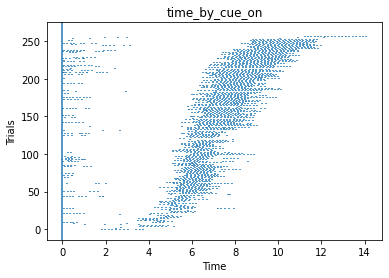

In [32]:
plot_licks_per_session(session_by_trial, trial_num_by_tw, 'time_by_cue_on')

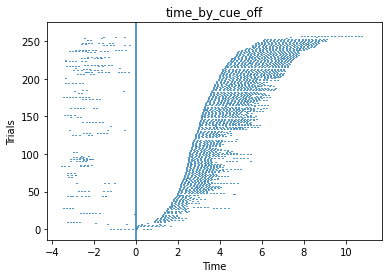

In [21]:
plot_licks_per_session(session_by_trial, trial_num_by_tw, 'time_by_cue_off')

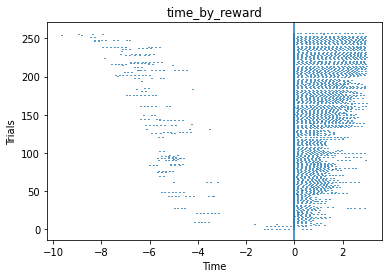

In [22]:
plot_licks_per_session(session_by_trial, trial_num_by_tw, 'time_by_reward')

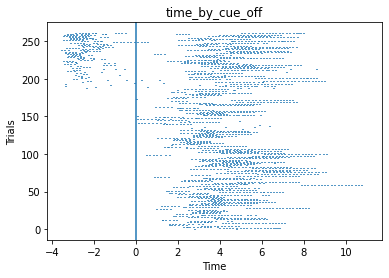

In [37]:
plot_licks_per_session(session_by_trial, trial_num_by_bg_licks, 'time_by_cue_off')

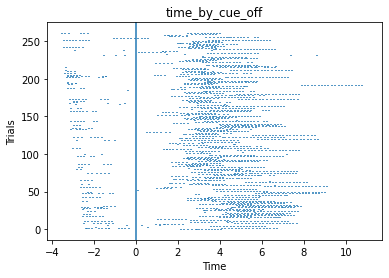

In [23]:
plot_licks_per_session(session_by_trial, trial_num_by_bg_len, 'time_by_cue_off')

<AxesSubplot: xlabel='reward', ylabel='Count'>

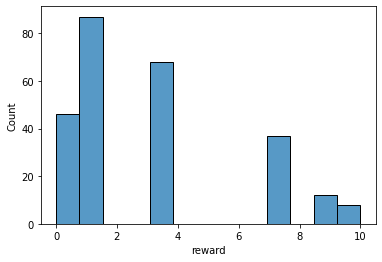

In [24]:
sns.histplot(data=all_trials, x="reward")